In [1]:
import torch
import time
from script.NeuralNets.Networks import SequentialNN
from script.settings import device, data_type

import script.DHOV.MultiDHOV as multidhov
from script.Verification.Verifier import SingleNeuronVerifier, MILPVerifier
import gurobipy as grp
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize
from script.NeuralNets.ICNNFactory import ICNNFactory
import matplotlib.pyplot as plt
import numpy as np
from script.DHOV.Sampling.PerGroupLineSearchSampling import PerGroupLineSearchSamplingStrategy
import math

In [2]:
import onnx
from onnx2pytorch import ConvertModel
from auto_LiRPA import BoundedModule, BoundedTensor, PerturbationLpNorm

from vnnlib.compat import read_vnnlib_simple
from collections import OrderedDict

In [3]:
onnx_model = onnx.load("../Experiments/mnist-net_256x4.onnx")
pytorch_model = ConvertModel(onnx_model)

nn = SequentialNN([28 * 28 * 1, 256, 256, 256, 256, 10])
state_dict = pytorch_model.state_dict()
my_state_dict = {}
for i, key in enumerate(state_dict):
    actual_index = i * 2
    my_state_dict[f"{actual_index}.bias"] = state_dict[f"_initializer_layers_{actual_index}_bias"]
    my_state_dict[f"{actual_index}.weight"] = state_dict[f"_initializer_layers_{actual_index}_weight"]
    if actual_index == 8:
        break
    
nn.load_state_dict(my_state_dict)

/home/ufuk/miniconda3/envs/autolirpa_icnn/lib/python3.10/site-packages/onnx2pytorch/convert/layer.py:30: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  layer.weight.data = torch.from_numpy(numpy_helper.to_array(weight))


<All keys matched successfully>

In [4]:
nn.to(device)

SequentialNN(
  (0): Linear(in_features=784, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=256, bias=True)
  (7): ReLU()
  (8): Linear(in_features=256, out_features=10, bias=True)
)

In [5]:
def imshow(img):
    img = img / 2 + .05  # revert normalization for viewing
    npimg = img.to("cpu").numpy()
    plt.imshow(npimg, cmap="gray")
    plt.show()

In [6]:
transform = Compose([ToTensor()])
training_data = MNIST(root="../../mnist", train=True, download=True, transform=transform)

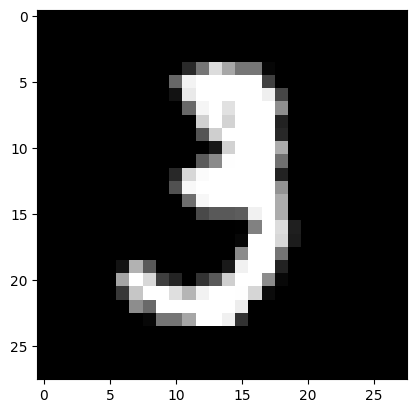

The label is 3
NN classifies image correctly as 3


In [7]:
image_index = 10

# epsilon radius
eps = 0.1

# whether a verification attempt should be done using just MILP encoding for comparison (can take long)
use_milp = False

image, label = training_data[image_index]
torch_image = torch.unsqueeze(image, 0).to(dtype=data_type).to(device)
imshow(torch_image[0][0])
print(f"The label is {label}")
if torch.argmax(nn(torch_image)).item() == label:
    print("NN classifies image correctly as {}".format(label))
else:
    print("NN classifies image wrong")

In [8]:
center = torch.flatten(torch_image)
input_bounds = [center - eps, center + eps]

In [21]:
sampling_strategy = PerGroupLineSearchSamplingStrategy(center, input_bounds, nn, keep_ambient_space=True, sample_new=False, sample_count=1000)



In [22]:
bounds_affine_out, bounds_layer_out = nn.calculate_box_bounds(input_bounds)
current_layer_index = 0
group_size = 300
parameter_list = list(nn.parameters())
affine_w, affine_b = parameter_list[0], parameter_list[0 + 1]

In [23]:
number_of_fixed_neurons = 0
fixed_neuron_per_layer_lower = []
fixed_neuron_per_layer_upper = []
num_fixed_neurons_layer = []
fix_upper = []
fix_lower = []
for neuron_index, (lb, ub) in enumerate(
        zip(bounds_affine_out[current_layer_index][0], bounds_affine_out[current_layer_index][1])):
    if ub <= 0:
        fix_upper.append(neuron_index)
        number_of_fixed_neurons += 1
    elif lb >= 0:
        fix_lower.append(neuron_index)
        number_of_fixed_neurons += 1
fixed_neuron_per_layer_lower.append(fix_lower)
fixed_neuron_per_layer_upper.append(fix_upper)
num_fixed_neurons_layer.append(len(fix_lower) + len(fix_upper))
print("    number of fixed neurons for current layer: {}".format(len(fix_lower) + len(fix_upper)))

    number of fixed neurons for current layer: 66


In [24]:
def get_num_of_groups(layer_size, group_size):
    number_of_groups = layer_size / group_size
    if number_of_groups < 0:
        number_of_groups *= -1
    number_of_groups = math.ceil(number_of_groups)
    return number_of_groups

In [25]:
def get_current_group_indices(num_neurons, group_size, fixed_neurons_lower, fixed_neurons_upper):
    group_indices = []
    current_group = []
    fixed_neuron_index = (fixed_neurons_lower + fixed_neurons_upper)
    for index in range(num_neurons):
        if index in fixed_neuron_index:
            continue
        else:
            current_group.append(index)
            if len(current_group) == group_size:
                group_indices.append(current_group)
                current_group = []

    if len(current_group) > 0:
        group_indices.append(current_group)
    return group_indices

In [26]:
all_group_indices = []

number_of_groups = get_num_of_groups(len(affine_b) - num_fixed_neurons_layer[current_layer_index],
                                     group_size)
group_indices = get_current_group_indices(len(affine_b), group_size,fixed_neuron_per_layer_lower[current_layer_index],fixed_neuron_per_layer_upper[current_layer_index])

all_group_indices.append(group_indices)

In [27]:
group_i = 0
list_of_icnns = []
net_size = [5, 1]
icnn_batch_size=10000
icnn_factory = ICNNFactory("logical", net_size, always_use_logical_layer=False)

list_of_icnns.append([])
index_to_select = torch.tensor(group_indices[group_i]).to(device)
size_of_icnn_input = len(index_to_select)
current_icnn = icnn_factory.get_new_icnn(size_of_icnn_input)
list_of_icnns[current_layer_index].append(current_icnn)

In [28]:
included_space, ambient_space = sampling_strategy.sampling_by_round(affine_w, affine_b, all_group_indices, None, current_layer_index, bounds_affine_out, bounds_layer_out, list_of_icnns)

In [29]:
from torch.utils.data import DataLoader
from script.dataInit import ConvexDataset
import script.DHOV.Normalisation as norm
from script.NeuralNets.trainFunction import train_icnn

group_inc_space = included_space[group_i]
group_amb_space = ambient_space[group_i]


mean = norm.get_mean(group_inc_space, group_amb_space)
std = norm.get_std(group_inc_space, group_amb_space)
group_norm_included_space, group_norm_ambient_space = norm.normalize_data(group_inc_space, group_amb_space, mean, std)

dataset = ConvexDataset(data=group_norm_included_space)
train_loader = DataLoader(dataset, batch_size=icnn_batch_size)
dataset = ConvexDataset(data=group_norm_ambient_space)
ambient_loader = DataLoader(dataset, batch_size=icnn_batch_size)

In [30]:
print(group_size)
print(len(group_inc_space))
print(len(group_amb_space))

300
500
500


In [31]:
t = time.time()
train_icnn(current_icnn, train_loader, ambient_loader, epochs=100, hyper_lambda=1,
                                       optimizer="SdLBFGS", adapt_lambda="included",preemptive_stop=True, verbose=False, print_last_loss=False)

print(time.time() - t)

0.3114650249481201


In [32]:
group_size = 20
100
cpu =  0.03320741653442383
cuda = 0.03522849082946777

10 000
cpu = 2.72
cuda = 2.65

20 000
cpu = 6.43
cuda = 5.73

50 000
cpu = 29.34
cuda = 21.33

100 000
cpu = 81.32830286026001
cuda = 66.44864082336426


group_size = 100

100
cpu = 0.04
cuda = 0.07

10 000
cpu = 5.39
cuda = 4.66


group_size = 200
cpu = 0.41
cuda = 0.31


group_size = 300

1 000
cpu = 0.37
cuda = 0.30

10 000
cpu = 9.61
cuda = 9.51

1 000 float32
cuda = 0.31

10 000 float32
cpu = 5.49
cuda = 3.06


SyntaxError: invalid syntax (3153037284.py, line 6)

# Test sampling

In [25]:
import script.DHOV.DataSampling as ds
included_sample_count = 10000
sample_space = torch.empty((0, affine_w.size(1)), dtype=data_type).to(device)
t = time.time()
for group in group_indices:
    sample_space_a = ds.sample_per_group(sample_space, included_sample_count, affine_w, center, eps, group, rand_samples_percent=0.2, rand_sample_alternation_percent=0.2)

print(time.time()-t)

TypeError: object of type 'float' has no len()

In [26]:
sample_space = torch.empty((len(group_indices), 0, affine_w.size(1)), dtype=data_type).to(device)
t = time.time()
sample_space_b = ds.sample_per_group_all_groups(sample_space, included_sample_count, affine_w, center, eps, group_indices, rand_samples_percent=0.2, rand_sample_alternation_percent=0.2)

print(time.time()-t)

TypeError: object of type 'float' has no len()

In [34]:
t=1

KeyboardInterrupt: 